# Decision Tree – Next-Day Direction Classifier

Binary classification: predict whether a stock's **next-day return is positive (1) or negative/zero (0)**.

A single decision tree is fully interpretable and can handle non-linear feature interactions, which logistic regression cannot.

**Time-based split:** train `< 2023-01-01`, test `≥ 2023-01-01`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Load Data

In [5]:
df = pd.read_csv('../data/merged_dataset.csv', parse_dates=['date'])
print(f'Shape: {df.shape}')
print(f'Date range: {df["date"].min().date()} – {df["date"].max().date()}')
df.head(3)

Shape: (1264542, 43)
Date range: 2016-02-10 – 2026-02-09


,date,ticker,adj_close,close,high,low,open,volume,daily_return,log_return,...,Yield_Spread,Regime_GMM,Regime_label,news_count,sentiment_mean,sentiment_sum,positive_count,negative_count,neutral_count,sentiment_ratio
0,2016-02-10,A,33.100433,35.849998,36.730000,35.529999,35.630001,3170000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-11,A,32.620323,35.330002,35.610001,34.939999,35.119999,3224000.0,-0.014505,-0.014611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-02-12,A,33.442055,36.220001,36.230000,35.520000,35.840000,3923600.0,0.025191,0.024879,...,0.027053,0.0,Stressful,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Feature Engineering

In [6]:
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# ── Target: next-day direction ────────────────────────────────────────────────
df['next_return'] = df.groupby('ticker')['daily_return'].shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

# ── Lagged returns ────────────────────────────────────────────────────────────
df['lag_return_1'] = df['daily_return']
df['lag_return_2'] = df.groupby('ticker')['daily_return'].shift(1)
df['lag_return_5'] = df.groupby('ticker')['daily_return'].shift(4)

# ── Price vs 20-day MA ────────────────────────────────────────────────────────
df['price_to_ma20'] = (
    df['close'] / df['rolling_mean_20'].replace(0, np.nan)
).replace([np.inf, -np.inf], np.nan) - 1

# ── Intraday range ────────────────────────────────────────────────────────────
df['hl_range'] = (df['high'] - df['low']) / df['close'].replace(0, np.nan)

# ── Overnight gap ─────────────────────────────────────────────────────────────
df['prev_close'] = df.groupby('ticker')['close'].shift(1)
df['oc_gap'] = (
    (df['open'] - df['prev_close']) / df['prev_close'].replace(0, np.nan)
).replace([np.inf, -np.inf], np.nan)

# ── Abnormal volume ───────────────────────────────────────────────────────────
df['vol_20ma'] = df.groupby('ticker')['volume'].transform(
    lambda x: x.rolling(20, min_periods=1).mean()
)
df['vol_norm'] = (df['volume'] / df['vol_20ma'].replace(0, np.nan)).clip(0, 10)

# ── News flag ─────────────────────────────────────────────────────────────────
df['has_news'] = (df['news_count'].fillna(0) > 0).astype(float)

# ── Log market cap ────────────────────────────────────────────────────────────
df['log_marketcap'] = np.log1p(df['Marketcap'].fillna(0))

# ── Impute sparse columns ─────────────────────────────────────────────────────
df['VIX']             = df['VIX'].fillna(df['VIX'].median())
df['Yield_Spread']    = df['Yield_Spread'].fillna(df['Yield_Spread'].median())
df['Regime_GMM']      = df['Regime_GMM'].fillna(df['Regime_GMM'].median())
df['sentiment_mean']  = df['sentiment_mean'].fillna(0)
df['sentiment_ratio'] = df['sentiment_ratio'].fillna(0)
df['Revenuegrowth']   = df['Revenuegrowth'].fillna(0)
df['Weight']          = df['Weight'].fillna(0)

# ── Sector encoding ───────────────────────────────────────────────────────────
df['Sector_encoded'] = df['Sector'].astype('category').cat.codes

print(f'Shape after feature engineering: {df.shape}')

Shape after feature engineering: (1264542, 57)


## 3. Feature Selection & Train / Test Split

In [8]:
FEATURE_COLS = [
    'lag_return_1', 'lag_return_2', 'lag_return_5',
    'rolling_std_20', 'price_to_ma20',
    'hl_range', 'oc_gap', 'vol_norm',
    'VIX', 'Yield_Spread', 'Regime_GMM',
    'sentiment_mean', 'sentiment_ratio', 'has_news',
    'log_marketcap', 'Revenuegrowth', 'Weight',
    'Sector_encoded',
]

model_df = df[FEATURE_COLS + ['target', 'date']].dropna()
print(f'Rows after dropna: {len(model_df):,}')

SPLIT_DATE = '2023-01-01'
train = model_df[model_df['date'] <  SPLIT_DATE]
test  = model_df[model_df['date'] >= SPLIT_DATE]

X_train, y_train = train[FEATURE_COLS].values, train['target'].values
X_test,  y_test  = test[FEATURE_COLS].values,  test['target'].values

# naive = max(y_test.mean(), 1 - y_test.mean())
# print(f'Train: {len(train):,}  |  Test: {len(test):,}')
# print(f'Naive baseline accuracy: {naive:.4f}')

Rows after dropna: 1,219,484


## 4. Selecting best depth with cross-validation

A single tree overfits quickly; we sweep `max_depth` to find the sweet spot.

In [9]:
baseline = max(0.5003, 0.5223, 0.4961, 0.4881)

<Axes: xlabel='depth'>

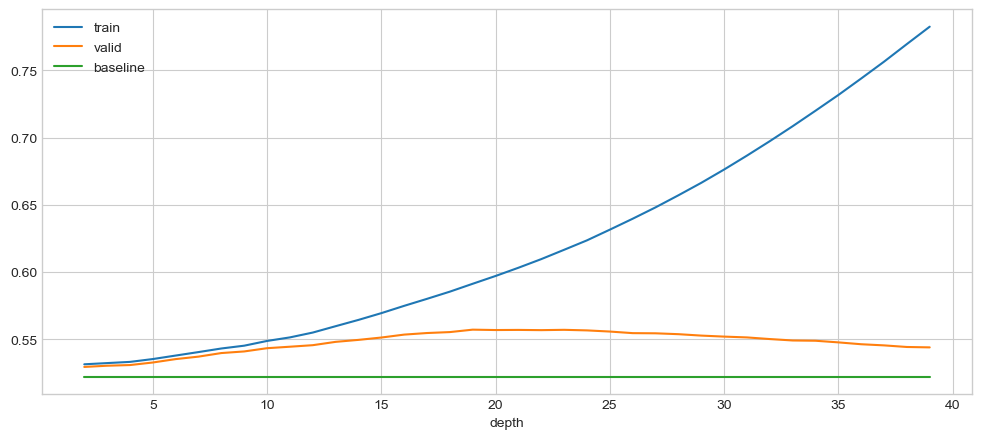

In [12]:
dtree = DecisionTreeClassifier(random_state=42)
parameters = {'max_depth': range(2, 40)}
dtreeCV = GridSearchCV(dtree, param_grid=parameters, cv=TimeSeriesSplit(n_splits=5), return_train_score=True, scoring='accuracy', n_jobs=-1)
dtreeCV.fit(X_train, y_train)

results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train'] = dtreeCV.cv_results_['mean_train_score']
results['valid'] = dtreeCV.cv_results_['mean_test_score']
results['baseline'] = baseline

results.plot.line(x='depth', y=['train', 'valid', 'baseline'])

## 5. Train Best Decision Tree

In [14]:
best_depth = dtreeCV.best_params_['max_depth']                                                                                          
print(f'Best depth from CV: {best_depth}')

y_pred_dt = dtreeCV.predict(X_test)

print('=== Decision Tree ===')
print(f'Accuracy : {accuracy_score(y_test, y_pred_dt):.4f}  (baseline: {baseline:.4f})')
print()
print(classification_report(y_test, y_pred_dt, target_names=['Down', 'Up']))

Best depth from CV: 19
=== Decision Tree ===
Accuracy : 0.5170  (baseline: 0.5223)

              precision    recall  f1-score   support

        Down       0.47      0.10      0.16    185824
          Up       0.52      0.90      0.66    203242

    accuracy                           0.52    389066
   macro avg       0.50      0.50      0.41    389066
weighted avg       0.50      0.52      0.42    389066



## 6. Tree Visualisation (depth = 3 for readability)

In [ ]:
# Train a shallow tree purely for visualisation
dt_viz = DecisionTreeClassifier(max_depth=3, min_samples_leaf=500, random_state=42)
dt_viz.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(22, 8))
plot_tree(
    dt_viz,
    feature_names=FEATURE_COLS,
    class_names=['Down', 'Up'],
    filled=True,
    rounded=True,
    fontsize=9,
    ax=ax,
)
ax.set_title('Decision Tree Structure (max_depth=3)', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Feature Importance

In [ ]:
fi_df = pd.DataFrame({
    'feature':    FEATURE_COLS,
    'importance': dt.feature_importances_,
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 7))
ax.barh(fi_df['feature'], fi_df['importance'], color='steelblue')
ax.set_title('Decision Tree Feature Importance')
ax.set_xlabel('Importance (mean decrease in impurity)')
plt.tight_layout()
plt.show()